In [2]:
#Checking if the authentication works
import tweepy


# Credentials

consumer_key = "cFf7im7BH68xO9qh3zEsv3nFz"
consumer_secret = "2QyodEVK63XYE5D9RFPAo0I53rhBOsNocQGpGB8rapmEqxDnJi"
access_token = "1265319352795975680-EJBIU55ZHZnjn8svR420cqVuU9evRL"
access_token_secret = "i8h2utF6b2l2Uh7Vpg6c2mnPOO1CuthGdbyWtHSWdIURP"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

public_tweets = api.home_timeline()
# for tweet in public_tweets:
#     print(tweet.text)
user = api.get_user('twitter')
print(user.screen_name)
print(user.followers_count)
for friend in user.friends():
   print(friend.screen_name)

Twitter
58062549
TwitterRetweets


In [4]:
# import tweepy
# import pandas as pd
# import time
# tweets = []

# def text_query_to_csv(text_query,count):
#     try:
#     # Pulling individual tweets from query
#         for tweet in api.search(q=text_query, count=count):

#           # Adding to list that contains all tweets
#           tweets.append((tweet.created_at,tweet.id,tweet.text))

#           # Creation of dataframe from tweets list
#           tweetsdf = pd.DataFrame(tweets,columns=['Datetime', 'Tweet Id', 'Text'])

#           # Converting dataframe to CSV
#           tweetsdf.to_csv('{}-tweets.csv'.format(text_query)) 

#     except BaseException as e:
#         print('failed on_status,',str(e))
#         time.sleep(3)

In [5]:
# text_query = 'covid19'
# count = 150

# # Calling function to query X amount of relevant tweets and create a CSV file
# text_query_to_csv(text_query, count)

In [7]:
# covid = pd.read_csv('covid19-tweets.csv')

In [8]:
# covid['Text'][0]

'"Get tough and fight (and arrest the bad ones)."\n\nGotcha, Spanky. We\'ll Pick You Up Shortly, for the Murder of 104,… https://t.co/sOSLEddINr'

In [9]:
# data = pd.read_html('https://www.mohfw.gov.in/')

In [31]:
# data

[                                               S. No.  \
 0                                                   1   
 1                                                   2   
 2                                                   3   
 3                                                   4   
 4                                                   5   
 5                                                   6   
 6                                                   7   
 7                                                   8   
 8                                                   9   
 9                                                  10   
 10                                                 11   
 11                                                 12   
 12                                                 13   
 13                                                 14   
 14                                                 15   
 15                                                 16   
 16           

In [14]:
#extract tweets having the hashtags given in the hashtag_list and write it to tweets.txt the program will continue running 
#until the user interrupts the kernel
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
 
# import twitter_credentials
 
consumer_key = "cFf7im7BH68xO9qh3zEsv3nFz"
consumer_secret = "2QyodEVK63XYE5D9RFPAo0I53rhBOsNocQGpGB8rapmEqxDnJi"
access_token = "1265319352795975680-EJBIU55ZHZnjn8svR420cqVuU9evRL"
access_token_secret = "i8h2utF6b2l2Uh7Vpg6c2mnPOO1CuthGdbyWtHSWdIURP"
# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        pass

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = StdOutListener(fetched_tweets_filename)
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class StdOutListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          

    def on_error(self, status):
        print(status)

 
if __name__ == '__main__':
 
    # Authenticate using config.py and connect to Twitter Streaming API.
    hash_tag_list = ["covid19news"]
    fetched_tweets_filename = "tweets.txt"

    twitter_streamer = TwitterStreamer()
    twitter_streamer.stream_tweets(fetched_tweets_filename, hash_tag_list)

{"created_at":"Sun May 31 14:04:06 +0000 2020","id":1267094507599822848,"id_str":"1267094507599822848","text":"\u0421\u0442\u0430\u0442\u0438\u0441\u0442\u0438\u043a\u0430 \u043a\u043e\u0440\u043e\u043d\u0430\u0432\u0438\u0440\u0443\u0441\u0430 - \u043f\u043e\u0441\u043b\u0435\u0434\u043d\u0438\u0435 \u043d\u043e\u0432\u043e\u0441\u0442\u0438 COVID-19\nhttps:\/\/t.co\/VrFmuPO87y\n\u0421\u0432\u0435\u0436\u0430\u044f \u0441\u0442\u0430\u0442\u0438\u0441\u0442\u0438\u043a\u0430 \u0438 \u043f\u043e\u0441\u043b\u0435\u0434\u043d\u0438\u0435 \u043d\u043e\u0432\u043e\u0441\u0442\u0438\u2026 https:\/\/t.co\/X5GaFk7A4B","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1264869229251231744,"id_str":"1264869229251231744","name":"\u0421\u043b\u0430\u0432\u0430

KeyboardInterrupt: 

In [6]:
#tweets from narendra modi having the elements of the hashtags_list
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
 
# import twitter_credentials
consumer_key = "cFf7im7BH68xO9qh3zEsv3nFz"
consumer_secret = "2QyodEVK63XYE5D9RFPAo0I53rhBOsNocQGpGB8rapmEqxDnJi"
access_token = "1265319352795975680-EJBIU55ZHZnjn8svR420cqVuU9evRL"
access_token_secret = "i8h2utF6b2l2Uh7Vpg6c2mnPOO1CuthGdbyWtHSWdIURP"
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

 
if __name__ == '__main__':
 
    # Authenticate using config.py and connect to Twitter Streaming API.
    hash_tag_list = ["covid19", "coronavirus", "gocoronago", "corona"]
    fetched_tweets_filename = "tweets.txt"

    twitter_client = TwitterClient('narendramodi')
    print(twitter_client.get_user_timeline_tweets(1))

[Status(_api=<tweepy.api.API object at 0x0000027E7FFFBA08>, _json={'created_at': 'Sun May 31 10:50:57 +0000 2020', 'id': 1267045897377992704, 'id_str': '1267045897377992704', 'text': 'लॉकडाउन में जीवन की रफ्तार थोड़ी धीमी तो हुई है, लेकिन हमें अपने आसपास प्रकृति की समृद्ध विविधता को देखने का अवसर… https://t.co/QmuFNlWk3X', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/QmuFNlWk3X', 'expanded_url': 'https://twitter.com/i/web/status/1267045897377992704', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [115, 138]}]}, 'source': '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 18839785, 'id_str': '18839785', 'name': 'Narendra Modi', 'screen_name': 'narendramodi', 'location': 'India', 'description': 'Prime Minist

In [9]:

from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
 
# import twitter_credentials
import numpy as np
import pandas as pd
consumer_key = "cFf7im7BH68xO9qh3zEsv3nFz"
consumer_secret = "2QyodEVK63XYE5D9RFPAo0I53rhBOsNocQGpGB8rapmEqxDnJi"
access_token = "1265319352795975680-EJBIU55ZHZnjn8svR420cqVuU9evRL"
access_token_secret = "i8h2utF6b2l2Uh7Vpg6c2mnPOO1CuthGdbyWtHSWdIURP"



# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="narendramodi", count=200)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    
    print(df)


                                                Tweets                   id  \
0    लॉकडाउन में जीवन की रफ्तार थोड़ी धीमी तो हुई ह...  1267045897377992704   
1    Some interesting details about Ayushman Bharat...  1267045786539319299   
2    अंतर्राष्ट्रीय योग दिवस जल्द ही आने वाला है। क...  1267045628304953344   
3    किसी भी परिस्थिति को बदलना इच्छाशक्ति के साथ ह...  1267045485103087616   
4    देशवासियों की सामूहिक संकल्पशक्ति के साथ एक और...  1267045385144426496   
..                                                 ...                  ...   
195  Ensuring all possible assistance to those who ...  1251391940039520256   
196  The world is fighting COVID-19 together. \n\nH...  1251391771365556225   
197  Proud of the Indian Railways team. \n\nThey’ve...  1251391513847902210   
198  RT @RailMinIndia: Indian Railways introduces i...  1251390967514570752   
199  RT @Dept_of_AHD: @Dept_of_AHD applauds @RailMi...  1251390897155043333   

     len                date                source 

132.175
373891
47461


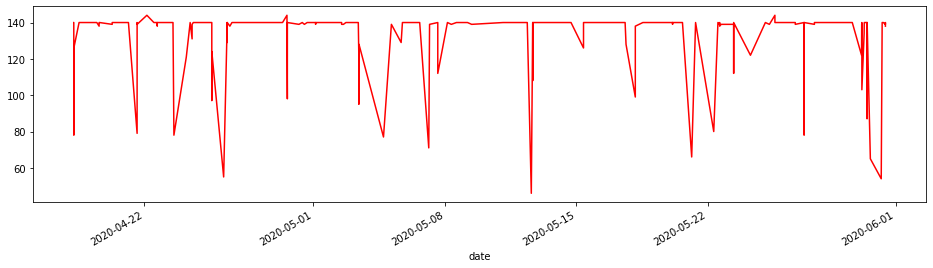

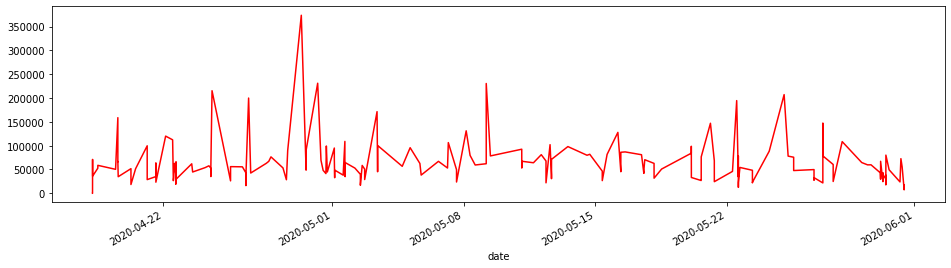

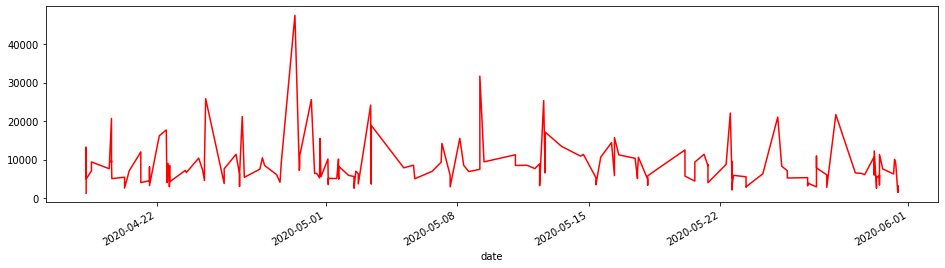

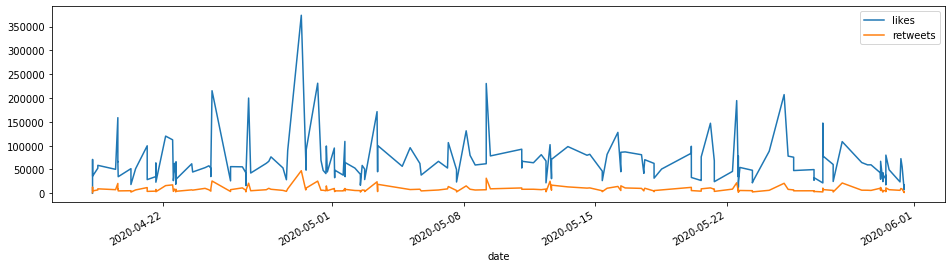

In [12]:

from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
 
# import twitter_credentials
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


consumer_key = "cFf7im7BH68xO9qh3zEsv3nFz"
consumer_secret = "2QyodEVK63XYE5D9RFPAo0I53rhBOsNocQGpGB8rapmEqxDnJi"
access_token = "1265319352795975680-EJBIU55ZHZnjn8svR420cqVuU9evRL"
access_token_secret = "i8h2utF6b2l2Uh7Vpg6c2mnPOO1CuthGdbyWtHSWdIURP"



# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="narendramodi", count=200)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    
    print(np.mean(df['len']))

    # Get the number of likes for the most liked tweet:
    print(np.max(df['likes']))

    # Get the number of retweets for the most retweeted tweet:
    print(np.max(df['retweets']))
    
    #print(df.head(10))

    # Time Series
    time_likes = pd.Series(data=df['len'].values, index=df['date'])
    time_likes.plot(figsize=(16, 4), color='r')
    plt.show()
    
    time_favs = pd.Series(data=df['likes'].values, index=df['date'])
    time_favs.plot(figsize=(16, 4), color='r')
    plt.show()

    time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    time_retweets.plot(figsize=(16, 4), color='r')
    plt.show()

#     Layered Time Series:
    time_likes = pd.Series(data=df['likes'].values, index=df['date'])
    time_likes.plot(figsize=(16, 4), label="likes", legend=True)

    time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
    plt.show()